In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import unidecode
import nltk

from tensorflow import keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

2021-10-10 04:47:10.734786: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-10 04:47:10.734933: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
train_data = pd.read_csv("../input/sentiment-analysis-on-movie-reviews/train.tsv.zip",sep = '\t')
test_data= pd.read_csv("../input/sentiment-analysis-on-movie-reviews/test.tsv.zip",sep = '\t')

In [5]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
print(len(train_data))
print(len(test_data))
train_data.info()

156060
66292
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [7]:
train_data.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [8]:
target = train_data['Sentiment'].unique()
target = list(map(str,target))
print(target)

['1', '2', '3', '4', '0']


In [9]:
train_data = train_data[['Phrase','Sentiment']]
train_data.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [10]:
def prep(text):
    text = str(text)
    text = text.replace("'","")
    train_tokenize = text_to_word_sequence(text,filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=" ")
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in train_tokenize if not i in stop_words]
    stopwordremove_text = ' '.join(stopwordremove)
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
    stemmer = PorterStemmer()
    stem_input = nltk.word_tokenize(numberremove_text)
    stem_text = ' '.join([stemmer.stem(word) for word in stem_input])
    lemmatizer = WordNetLemmatizer()
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J":wordnet.ADJ,
                   "N":wordnet.NOUN,
                   "V":wordnet.VERB,
                   "R":wordnet.ADV}
        return tag_dict.get(tag,wordnet.NOUN)
    
    lem_input = nltk.word_tokenize(stem_text)
    lem_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
    
    return lem_text

In [11]:
train_data['Phrase'] = train_data['Phrase'].apply(prep)
phrase = train_data['Phrase']
sentiment = train_data['Sentiment']
phrase.head()


0    seri escapad demonstr adag good goo also good ...
1                  seri escapad demonstr adag good goo
2                                                 seri
3                                                     
4                                                 seri
Name: Phrase, dtype: object

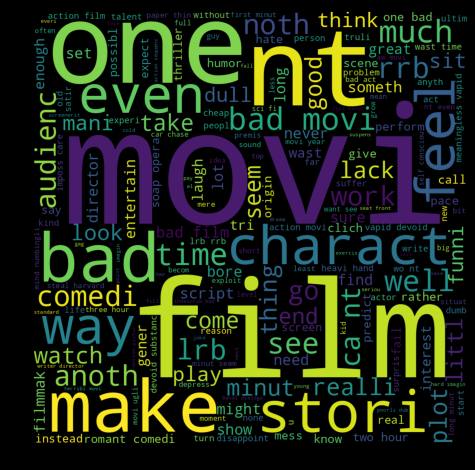

In [12]:
def word_collect(phrase,sentiment):
    words = []
    for i in phrase[phrase['Sentiment']==sentiment]['Phrase'].str.split():
        for j in i :
            words.append(j)
    return words

negative = word_collect(train_data,0)
less_negative = word_collect(train_data,1)
neutral = word_collect(train_data,2)
less_positive = word_collect(train_data,3)
positive =  word_collect(train_data,4)

cloud_neg =   WordCloud(background_color='black',width=1000,height=1000).generate(' '.join(negative))
plt.figure(figsize=(15,8),facecolor='k')
plt.imshow(cloud_neg)

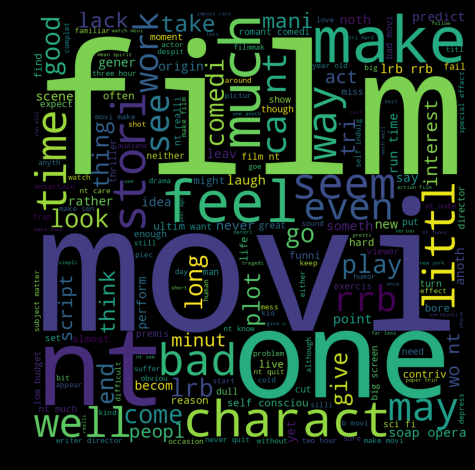

In [13]:
cloud_less_neg =  WordCloud(background_color='black',width = 1000,height=1000).generate(' '.join(less_negative))
plt.figure(figsize=(15,8),facecolor='k')
plt.imshow(cloud_less_neg)

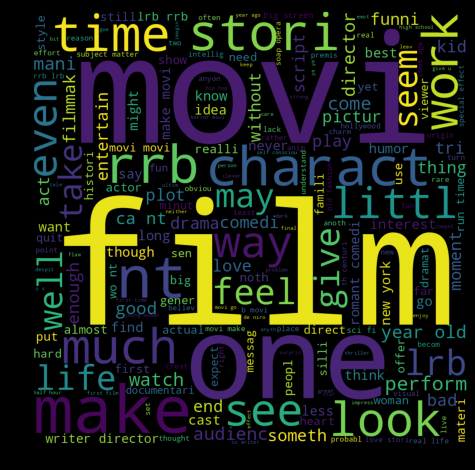

In [14]:
cloud_neutral =  WordCloud(background_color='black',width = 1000,height=1000).generate(' '.join(neutral))
plt.figure(figsize=(15,8),facecolor='k')
plt.imshow(cloud_neutral)

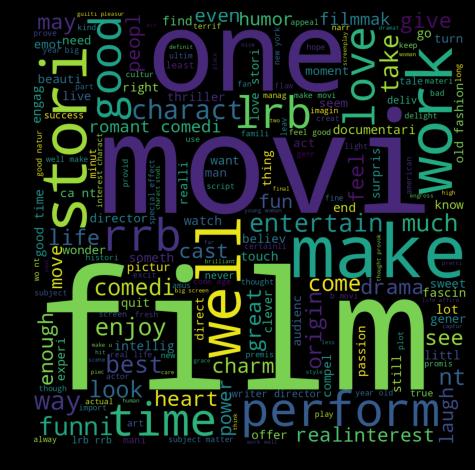

In [15]:
cloud_less_pos =  WordCloud(background_color='black',width = 1000,height=1000).generate(' '.join(less_positive))
plt.figure(figsize=(15,8),facecolor='k')
plt.imshow(cloud_less_pos)

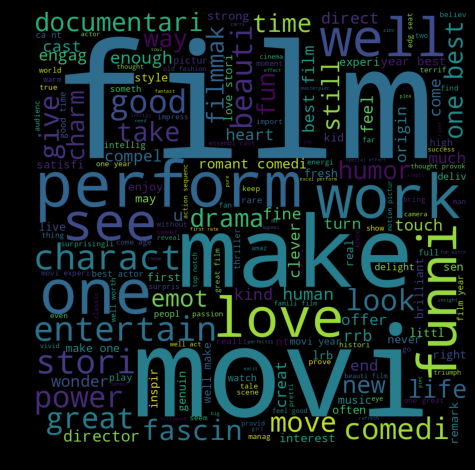

In [16]:
cloud_pos =  WordCloud(background_color='black',width = 1000,height=1000).generate(' '.join(positive))
plt.figure(figsize=(15,8),facecolor='k')
plt.imshow(cloud_pos)

In [17]:
data_dup = list(zip(phrase,sentiment))
train_data = pd.DataFrame(data_dup,columns=['Phrase','Sentiment'])
train_data.head(10)

,Phrase,Sentiment
0,seri escapad demonstr adag good goo also good ...,1
1,seri escapad demonstr adag good goo,2
2,seri,2
3,,2
4,seri,2
5,escapad demonstr adag good goo,2
6,,2
7,escapad demonstr adag good goo,2
8,escapad,2
9,demonstr adag good goo,2


In [18]:
train_data["Phrase"].replace('',np.nan,inplace=True)
train_data.dropna(subset = ['Phrase'],inplace=True)
train_data.head(10)

,Phrase,Sentiment
0,seri escapad demonstr adag good goo also good ...,1
1,seri escapad demonstr adag good goo,2
2,seri,2
4,seri,2
5,escapad demonstr adag good goo,2
7,escapad demonstr adag good goo,2
8,escapad,2
9,demonstr adag good goo,2
10,demonstr adag,2
11,demonstr,2


In [19]:
phrase =  train_data['Phrase']
sentiment = train_data['Sentiment']
phrase.head()

0    seri escapad demonstr adag good goo also good ...
1                  seri escapad demonstr adag good goo
2                                                 seri
4                                                 seri
5                       escapad demonstr adag good goo
Name: Phrase, dtype: object

In [20]:
X_train,X_test,y_train,y_test = train_test_split(phrase,sentiment,test_size=0.35,random_state=50,shuffle=True,stratify=sentiment)
print(len(X_train))
print(len(X_test))

100538
54136


In [21]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

dt.fit(X_train, y_train)

test_predict = dt.predict(X_test)

train_accuracy = round(dt.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(test_predict, y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, y_test, target_names=target))

Decision Tree Train Accuracy Score : 88% 
Decision Tree Test Accuracy Score  : 61% 

              precision    recall  f1-score   support

           1       0.41      0.40      0.41      2543
           2       0.50      0.48      0.49      9910
           3       0.75      0.72      0.73     28700
           4       0.48      0.53      0.50     10518
           0       0.35      0.46      0.39      2465

    accuracy                           0.61     54136
   macro avg       0.50      0.52      0.51     54136
weighted avg       0.62      0.61      0.61     54136



In [22]:
sgd = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier()),
               ])

sgd.fit(X_train, y_train)

test_predict = sgd.predict(X_test)

train_accuracy = round(sgd.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(test_predict, y_test)*100)

print("SVM Train Accuracy Score : {}% ".format(train_accuracy ))
print("SVM Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, y_test, target_names=target))

SVM Train Accuracy Score : 57% 
SVM Test Accuracy Score  : 56% 

              precision    recall  f1-score   support

           1       0.07      0.51      0.12       330
           2       0.11      0.48      0.18      2139
           3       0.95      0.57      0.71     45951
           4       0.22      0.50      0.30      4999
           0       0.12      0.53      0.19       717

    accuracy                           0.56     54136
   macro avg       0.29      0.52      0.30     54136
weighted avg       0.83      0.56      0.64     54136



In [23]:
test_data.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [24]:
test_data['Phrase']=test_data['Phrase'].apply(prep)
test_id = test_data['PhraseId']
test_text = test_data['Phrase']
y_predict = dt.predict(test_text)

In [25]:
submission = pd.DataFrame(list(zip(test_id, y_predict)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
5,156066,3
6,156067,3
7,156068,2
8,156069,2
9,156070,2


In [26]:
submission.to_csv('submission.csv',index=False)
submission.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
